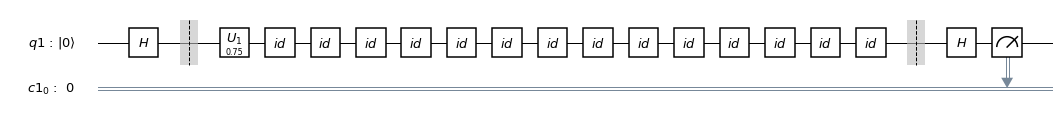

In [2]:
# t2_ramsey.py - Original at https://github.com/Qiskit/ibmqx-user-guides/blob/master/qiskit/python/t2_ramsey.py
# We modified this script to run on the latest version of Qiskit which gets rid of some deprecated functions.
# We also include some details to help explain what is going on

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer


# Define the Quantum and Classical Registers
q = QuantumRegister(1)
c = ClassicalRegister(1)

# Build the circuits 
# the circuit 'pre' will set up the |+> state for us.
pre = QuantumCircuit(q, c)
pre.h(q) # Add a hadamard gate to qubit
pre.barrier() # This is something about numerical optimizations, I think? Not quite sure, we should try running without it.

# The circuit 'meas_x' will rotate back to the z basis and measure the state
meas_x = QuantumCircuit(q, c)
meas_x.barrier()
meas_x.h(q)
meas_x.measure(q, c)

# We generate many 'middle' circuits that vary the wait time between 'pre' and 'meas_x' circuits.
circuits = []

# The number of circuits, and therefore data points, is controlled by the length of this vector.
exp_vector = range(1,51)

# The phase is slightly mysterious to me, Bob has an idea of what this is about.
phase = 0.0

for exp_index in exp_vector:
    middle = QuantumCircuit(q, c)
    phase = phase + 6*np.pi/len(exp_vector)
    middle.u1(phase,q[0]) # This is the only difference between what happens here and our attempt at T2 measurement.
    for i in range(7*exp_index):
        middle.iden(q)
    circuits.append(pre + middle + meas_x)
    
# Visualize one of the circuits we will run to do the Ramsey experiment. 
# You can see the U_1 phase gate implemented after the first H.
circuits[1].draw(output='mpl')

In [3]:
# This allows us to do the experiment using 'statevector_simulator' backend. There is no noise added.
# This simulates the statevector, and we can directly access the coefficients.
backend = BasicAer.get_backend('statevector_simulator')
job = execute(circuits, backend)
result = job.result()

gs_probs = []
for exp_index in exp_vector:
    outputstate = result.get_statevector(circuits[exp_index - 1], decimals=3)
    gs_probs.append(np.abs(outputstate[0]))   

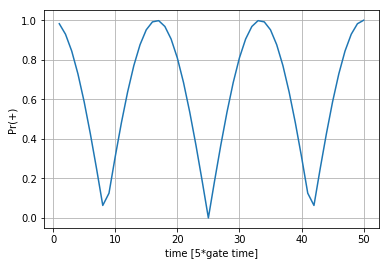

In [4]:
# Plot the result
plt.plot(exp_vector, gs_probs)
plt.xlabel('time [5*gate time]')
plt.ylabel('Pr(+)')
plt.grid(True)
plt.show()

In [5]:
# Same thing with a different simulator - 'qasm_simulator.' Here we do not get to access the state vector,
# we can do measurements and read out the result from the classical bit. Therefore, we need to run the 
# experiments over and over to get statistics.

backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
# Run the experiment 'shots' times over.
job = execute(circuits, backend, shots = 1024 )
result = job.result()

gs_counts = []
gs_errors = []
for exp_index in exp_vector:
    outputstate = result.get_counts(circuits[exp_index - 1])
    try:
        p0 = outputstate['0']/shots
    except KeyError:
        p0 = 0
    gs_counts.append(p0)   
    gs_errors.append(np.sqrt(p0*(1-p0)/shots))

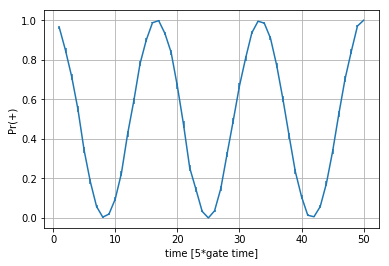

In [10]:
# Plot the result

plt.errorbar(exp_vector, gs_counts, gs_errors)
plt.xlabel('time [5*gate time]')
plt.ylabel('Pr(+)')
plt.grid(True)
plt.show()

In [11]:
# Use token to run on a real IBM Q device
from qiskit import IBMQ
## You had 
##    IBMQ.save_account('API_KEY')
##    overwrite = True
## I changed it to
##    IBMQ.save_account('API_KEY', overwrite = True)
## 'overwrite' is an option for the function save_account, so it has to be given in the () you use when you call the function.
## after I made that change it worked for me. Does this make sense?
IBMQ.save_account('7058448b5f63e3dd45f603b789e31301e4b54cb69f0037300dc2cd25cc8d2e7eb2b22248face786787861de1cd285e0f18d3c20a1ed09594e638eb8aebf6cdcf', overwrite = True)

In [12]:
IBMQ.load_accounts()

/Users/rwang/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqprovider.py:251: UserWarning: Credentials are already in use.
  warnings.warn('Credentials are already in use.')


In [13]:
print("Available backends:")
IBMQ.backends()

Available backends:


[<IBMQBackend('ibmqx4') from IBMQ()>,
 <IBMQBackend('ibmqx2') from IBMQ()>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ()>,
 <IBMQBackend('ibmq_qasm_simulator') from IBMQ()>]

In [16]:
# In order to run this on the real quantum computers available from IBM, we need to do some administrative stuff.
# You may have already done this, if not I think it is necessary to proceed. Information on how is given at
# https://qiskit.org/documentation/getting_started.html#circuit-basics.

from qiskit.providers.ibmq import least_busy, IBMQ

# large_enough_devices = IBMQ.backends(filters=lambda x: x.configuration().n_qubits > 3 and not x.configuration().simulator)
# backend = least_busy(large_enough_devices)

choose_device = IBMQ.backends(filters = lambda x:x.name() == 'ibmqx2' and not x.configuration().simulator) 
backend = least_busy(choose_device)

# backend = least_busy(large_enough_de vices)
# print("The best backend is " + backend.name())
print("We are using the backend " + backend.name())

We are using the backend ibmqx2


In [20]:
# do measurements and read out the result from the classical bit

backend = backend
shots = 1024

job = execute(circuits, backend, shots = 1024)
result = job.result()

gs_counts = []
gs_errors = []
for exp_index in exp_vector:
    outputstate = result.get_counts(circuits[exp_index - 1])
    try:
        p0 = outputstate['0']/shots
    except KeyError:
        p0 = 0
    gs_counts.append(p0)   
    gs_errors.append(np.sqrt(p0*(1-p0)/shots))

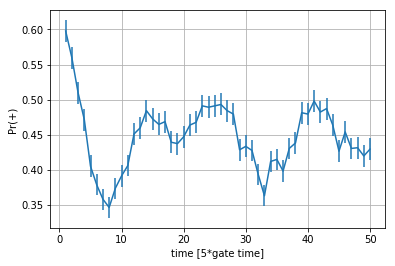

In [21]:
# Plot the result

plt.errorbar(exp_vector, gs_counts, gs_errors)
plt.xlabel('time [5*gate time]')
plt.ylabel('Pr(+)')
plt.grid(True)
plt.show()

In [55]:
print(gs_counts)

[0.828125, 0.5732421875, 0.3603515625, 0.2900390625, 0.359375, 0.4716796875, 0.5859375, 0.6806640625, 0.6728515625, 0.580078125, 0.486328125, 0.4755859375, 0.4755859375, 0.505859375, 0.4892578125, 0.5595703125, 0.5673828125, 0.5400390625, 0.5361328125, 0.515625, 0.53125, 0.5341796875, 0.541015625, 0.5400390625, 0.537109375, 0.4990234375, 0.564453125, 0.529296875, 0.5380859375, 0.544921875, 0.5400390625, 0.53125, 0.541015625, 0.568359375, 0.5263671875, 0.5400390625, 0.5771484375, 0.5537109375, 0.54296875, 0.5517578125, 0.517578125, 0.5302734375, 0.5546875, 0.5361328125, 0.52734375, 0.533203125, 0.5537109375, 0.54296875, 0.568359375, 0.552734375]


In [ ]:
from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview

backend_monitor(backend)

In [7]:
backend.properties()

BackendProperties(backend_name='ibmqx2', backend_version='1.0.0', gates=[Gate(gate='u1', parameters=[Nduv(date=datetime.datetime(2019, 4, 29, 11, 0, 47, tzinfo=tzutc()), name='gate_error', unit='', value=0.0)], qubits=[0]), Gate(gate='u2', parameters=[Nduv(date=datetime.datetime(2019, 4, 29, 11, 0, 47, tzinfo=tzutc()), name='gate_error', unit='', value=0.004380856821671664)], qubits=[0]), Gate(gate='u3', parameters=[Nduv(date=datetime.datetime(2019, 4, 29, 11, 0, 47, tzinfo=tzutc()), name='gate_error', unit='', value=0.008761713643343327)], qubits=[0]), Gate(gate='u1', parameters=[Nduv(date=datetime.datetime(2019, 4, 29, 11, 0, 47, tzinfo=tzutc()), name='gate_error', unit='', value=0.0)], qubits=[1]), Gate(gate='u2', parameters=[Nduv(date=datetime.datetime(2019, 4, 29, 11, 0, 47, tzinfo=tzutc()), name='gate_error', unit='', value=0.003091708656797032)], qubits=[1]), Gate(gate='u3', parameters=[Nduv(date=datetime.datetime(2019, 4, 29, 11, 0, 47, tzinfo=tzutc()), name='gate_error', unit=